## Missing libraries?

Uncomment and run the cell for any of the libraries you are missing.

**NumPy**

In [1]:
#!pip install numpy

**Pandas**

In [2]:
#!pip install pandas

**Seaborn**

In [3]:
#!pip install seaborn

**Matplotlib**

In [4]:
#!pip install matplotlib

**IPython**

In [5]:
#!pip install ipython

**Scikit-Learn**

In [6]:
#!pip install scikit-learn

## Credit Card Fraud Kaggle Project

Logistic Regression and a random forest model to predict fraudulent transactions on credit card data.

This notebook is a scikit-learn conversion of the original statsmodels implementation.

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, f1_score, classification_report, average_precision_score, precision_recall_curve, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

#Random state and hyperparameters.
rState = 42
test_size = 0.31
prediction_threshold = 0.1275

In [8]:
#Load the dataset.
df = pd.read_csv("fraud_data.csv")

In [9]:
df.head() #Display the first few rows of the dataset to understand its structure and contents.

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,04-01-2019 00:58,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1
1,04-01-2019 15:06,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1
2,04-01-2019 22:37,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1
3,04-01-2019 23:06,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1
4,04-01-2019 23:59,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1


In [10]:
print(df.info()) #Display the information about the dataset, including the number of rows, columns, and data types.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14446 entries, 0 to 14445
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  14446 non-null  object 
 1   merchant               14446 non-null  object 
 2   category               14446 non-null  object 
 3   amt                    14446 non-null  float64
 4   city                   14446 non-null  object 
 5   state                  14446 non-null  object 
 6   lat                    14446 non-null  float64
 7   long                   14446 non-null  float64
 8   city_pop               14446 non-null  int64  
 9   job                    14446 non-null  object 
 10  dob                    14446 non-null  object 
 11  trans_num              14446 non-null  object 
 12  merch_lat              14446 non-null  float64
 13  merch_long             14446 non-null  float64
 14  is_fraud               14446 non-null  object 
dtypes:

In [11]:
#Value counts show that the data is imbalanced. Which is what would be expected for fraudulent activity.
df['is_fraud'].value_counts() #0 is not a fraud, 1 is a fraud.

is_fraud
0                         12600
1                          1844
1"2020-12-24 16:56:24"        1
0"2019-01-01 00:00:44"        1
Name: count, dtype: int64

In [12]:
#Dropping the two observations that are not a 0 or 1 but also have a timestamp.
df = df[df['is_fraud'].isin(['1', '0'])]

In [13]:
#This is not from baseline model. Remove transaction number, city, state, job, and merchant columns.
df.drop(columns=['trans_num', 'city', 'state', 'job', 'merchant'], inplace=True)

In [14]:
df.head() #Display the first few rows of the dataset after dropping the specified columns.

,trans_date_trans_time,category,amt,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud
0,04-01-2019 00:58,grocery_net,14.37,64.7556,-165.6723,145,09-11-1939,65.654142,-164.722603,1
1,04-01-2019 15:06,shopping_net,966.11,64.7556,-165.6723,145,09-11-1939,65.468863,-165.473127,1
2,04-01-2019 22:37,misc_pos,49.61,64.7556,-165.6723,145,09-11-1939,65.347667,-165.914542,1
3,04-01-2019 23:06,grocery_pos,295.26,64.7556,-165.6723,145,09-11-1939,64.445035,-166.080207,1
4,04-01-2019 23:59,health_fitness,18.17,64.7556,-165.6723,145,09-11-1939,65.447094,-165.446843,1


#### Feature Engineering

In [15]:
#Creating an age category.
df['dob'][0]

df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format="%d-%m-%Y %H:%M") #Convert the date into a datetime object.

#Age of the person when they made the transaction.
df['age'] = (df['trans_date_trans_time'] - pd.to_datetime(df['dob'], format="%d-%m-%Y")).dt.days // 365 #Convert the date into years for age.

#Extract the time of the day.
df['time_of_day'] = df['trans_date_trans_time'].dt.strftime('%H:%M')

#Hour of day.
df['hour'] = df['trans_date_trans_time'].dt.hour

#Extract day of the week.
df['day_of_week'] = df['trans_date_trans_time'].dt.day_name()

#Create a new measure of the distance between lat and long and merchant lat and long.
#Define the Haversine function. This is from the baseline model, but we don't use the feature in the final model.
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371.0  #Radius of Earth in kilometers.
    distance = r * c
    return distance
    
#Apply Haversine function row-wise.
df['distance_km'] = df.apply(
    lambda row: haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']),
    axis=1
)

In [16]:
df.head() #Display the first few rows of the dataset after adding the distance column.

,trans_date_trans_time,category,amt,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,age,time_of_day,hour,day_of_week,distance_km
0,2019-01-04 00:58:00,grocery_net,14.37,64.7556,-165.6723,145,09-11-1939,65.654142,-164.722603,1,79,00:58,0,Friday,109.285552
1,2019-01-04 15:06:00,shopping_net,966.11,64.7556,-165.6723,145,09-11-1939,65.468863,-165.473127,1,79,15:06,15,Friday,79.856896
2,2019-01-04 22:37:00,misc_pos,49.61,64.7556,-165.6723,145,09-11-1939,65.347667,-165.914542,1,79,22:37,22,Friday,66.807915
3,2019-01-04 23:06:00,grocery_pos,295.26,64.7556,-165.6723,145,09-11-1939,64.445035,-166.080207,1,79,23:06,23,Friday,39.636227
4,2019-01-04 23:59:00,health_fitness,18.17,64.7556,-165.6723,145,09-11-1939,65.447094,-165.446843,1,79,23:59,23,Friday,77.611529


In [17]:
#Transform specific data into categorical variables.
df['category'] = df['category'].astype('category')
df['day_of_week'] = df['day_of_week'].astype('category')
df['hour'] = df['hour'].astype('category')
df['is_fraud'] = df['is_fraud'].astype(int)

In [18]:
#Check the variable types.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 14444 entries, 0 to 14445
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   trans_date_trans_time  14444 non-null  datetime64[ns]
 1   category               14444 non-null  category      
 2   amt                    14444 non-null  float64       
 3   lat                    14444 non-null  float64       
 4   long                   14444 non-null  float64       
 5   city_pop               14444 non-null  int64         
 6   dob                    14444 non-null  object        
 7   merch_lat              14444 non-null  float64       
 8   merch_long             14444 non-null  float64       
 9   is_fraud               14444 non-null  int64         
 10  age                    14444 non-null  int64         
 11  time_of_day            14444 non-null  object        
 12  hour                   14444 non-null  category      
 13  day_of

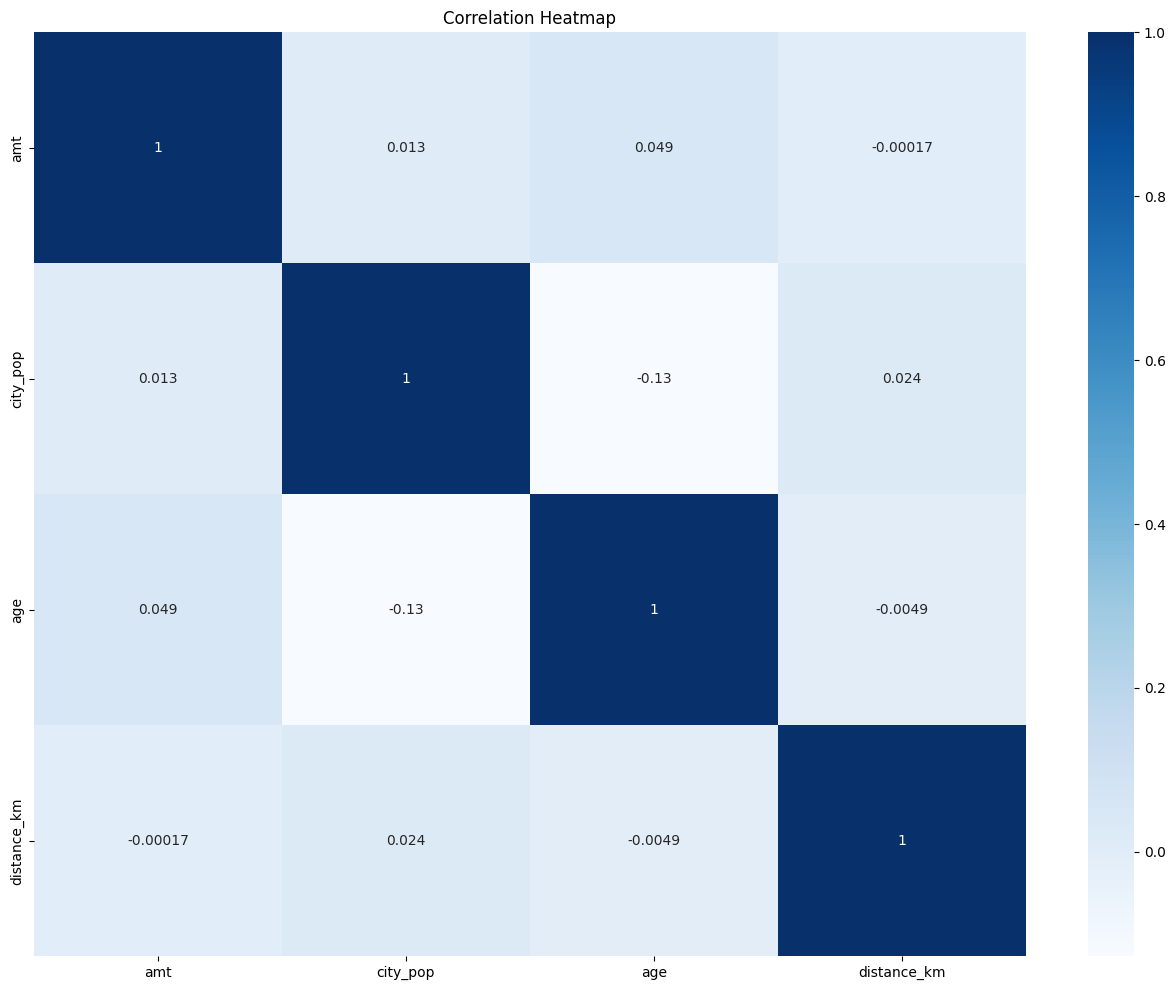

In [19]:
#Create a correlation matrix to show that the numeric data is not correlated.
quantdata = df[["amt", "city_pop", "age", "distance_km"]]
corr_matrix = quantdata.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title("Correlation Heatmap")
plt.show()

In [20]:
#No NAs in dataset before data modeling.
nan_counts = df.isna().sum()
print(nan_counts)

trans_date_trans_time    0
category                 0
amt                      0
lat                      0
long                     0
city_pop                 0
dob                      0
merch_lat                0
merch_long               0
is_fraud                 0
age                      0
time_of_day              0
hour                     0
day_of_week              0
distance_km              0
dtype: int64


### Logistic Regression to Predict Fraud (scikit-learn version)

In [21]:
#Split into Train and Test sets without one-hot encoding.
train_data, test_data = train_test_split(df, test_size=test_size, random_state=rState)

In [22]:
#Extract feature columns.
X_features = ['age', 'amt', 'hour', 'category']

#Had to use ChatGPT to figure out how to get the categorical variables into the model for help in converting statsmodels to scikit.
#Use get_dummies with drop_first=False to most closely match statsmodels treatment of categorical vars. This one-hot encodes the hour and category features.
X_train = pd.get_dummies(train_data[X_features], columns=['hour', 'category'], drop_first=False)
y_train = train_data['is_fraud']
X_test = pd.get_dummies(test_data[X_features], columns=['hour', 'category'], drop_first=False)
y_test = test_data['is_fraud']

#Initialize the logistic regression model and fit to training data.
log_reg = LogisticRegression(max_iter=1000, random_state=rState, solver='liblinear')
log_reg.fit(X_train, y_train); #Use semicolon to suppress logistic regression output.

In [23]:
#Predict on the test set.
preds = log_reg.predict_proba(X_test)[:, 1]  #Probability of class 1 (fraud)

#Add prediction and correct prediction columns to the test dataframe.
test_data['prob'] = preds
test_data['prediction'] = np.where(test_data['prob'] > prediction_threshold, 1, 0)
test_data['correct_prediction'] = np.where(test_data['prediction'] == test_data['is_fraud'], 1, 0)

#Calculate naive accuracy, model accuracy, and AUPRC.
naive_accuracy = 1 - test_data['is_fraud'].sum() / len(test_data)
accuracy = test_data['correct_prediction'].sum() / len(test_data)
auprc = average_precision_score(test_data['is_fraud'], preds)

#Display Results.
print(f"Naive Accuracy: {naive_accuracy}")
print(f"Model Accuracy: {accuracy}")
print(f"AUPRC: {auprc}")
print(f"Number of test samples: {len(test_data)}")

Naive Accuracy: 0.8702545779365789
Model Accuracy: 0.8624385886556498
AUPRC: 0.8109416874446325
Number of test samples: 4478


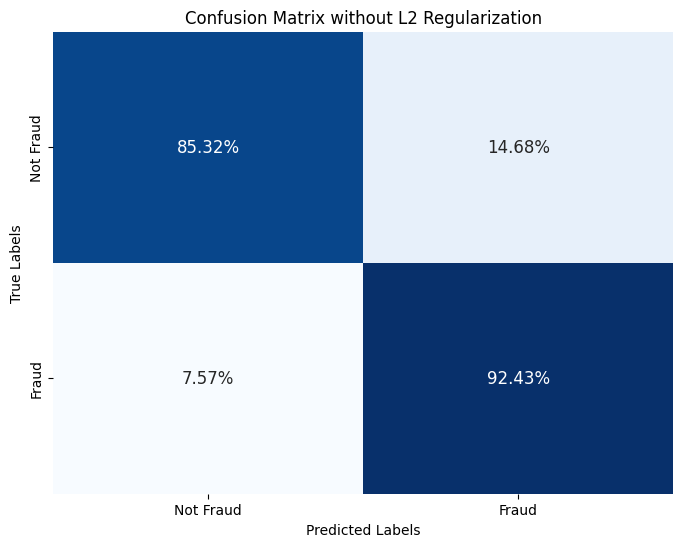

-----------------------------------------------------------------
                    Classification Report
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      3897
           1       0.48      0.92      0.64       581

    accuracy                           0.86      4478
   macro avg       0.74      0.89      0.78      4478
weighted avg       0.92      0.86      0.88      4478



In [24]:
#Compute the confusion matrix.
cm = confusion_matrix(test_data['is_fraud'], test_data['prediction'], normalize="true")

#Define labels for the classes.
labels = ["Not Fraud", "Fraud"]

#Create confusion matrix plot.
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels, annot_kws={"size": 12})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix without L2 Regularization')
plt.show()

#Print classifcation report.
print("-" * 65)
print(' ' * 20 + "Classification Report")
print(classification_report(test_data['is_fraud'], test_data['prediction']))

# AUPRC Without L2 Regularization

AUPRC: 0.8109


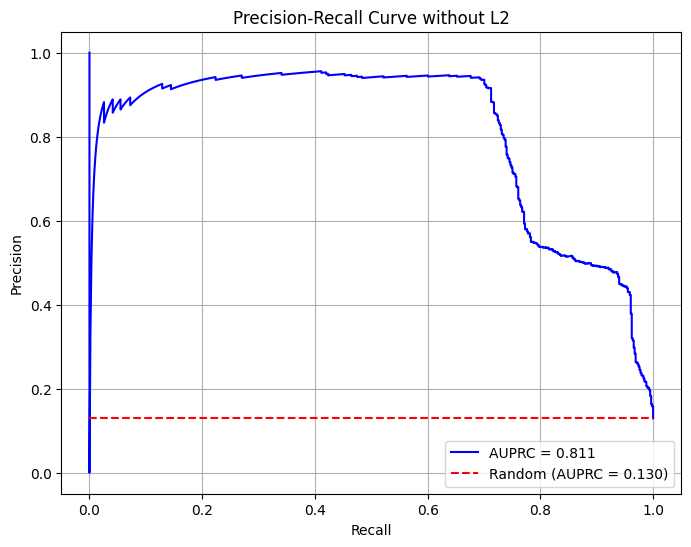

In [25]:
#Calculate precision-recall curve.
precision, recall, thresholds = precision_recall_curve(test_data['is_fraud'], test_data['prob'])

#Calculate area under precision-recall curve.
auprc = average_precision_score(test_data['is_fraud'], test_data['prob'])

#Print the AUPRC score without L2 regularization.
print(f"AUPRC: {auprc:.4f}")

#Plot precision-recall curve.
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label=f'AUPRC = {auprc:.3f}')

#Add a line for random performance (class imbalance ratio).
random = len(test_data[test_data['is_fraud'] == 1]) / len(test_data)
plt.plot([0, 1], [random, random], 'r--', label=f'Random (AUPRC = {random:.3f})')

#Add labels and title, then show the plot.
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve without L2')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Learning Curve

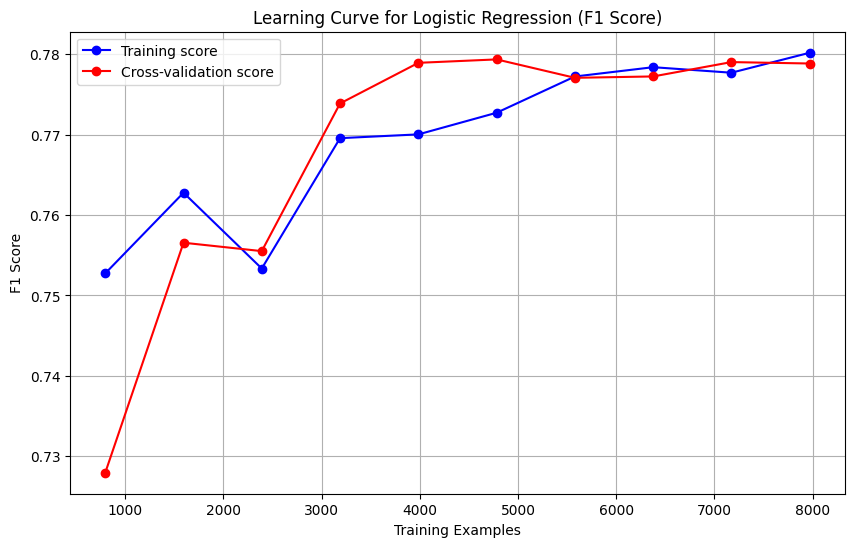

Training examples	Training Score	Validation Score
797			0.7527		0.7280
1594			0.7628		0.7566
2391			0.7533		0.7555
3188			0.7695		0.7739
3986			0.7700		0.7789
4783			0.7727		0.7793
5580			0.7772		0.7771
6377			0.7784		0.7772
7174			0.7777		0.7790
7972			0.7802		0.7788


In [26]:
#Calculate learning curve to show if the model is overfitting or underfitting.
train_sizes, train_scores, valid_scores = learning_curve(log_reg, X_train, y_train, 
    train_sizes=np.linspace(0.1, 1.0, 10),  #Train on 10%, 20%, ..., 100% of data.
    cv=5,  #5-fold cross-validation.
    scoring='f1',  #Use F1 score for imbalanced data.
    n_jobs=-1  #Use all available cores to make process faster.
)

#Calculate mean and standard deviation of training and validation scores.
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

#Plot the learning curve.
plt.figure(figsize=(10, 6))
plt.title("Learning Curve for Logistic Regression (F1 Score)")
plt.xlabel("Training Examples")
plt.ylabel("F1 Score")
plt.grid()

plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training score")
plt.plot(train_sizes, valid_mean, 'o-', color="red", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

#Print numeric results at each training size.
print("Training examples\tTraining Score\tValidation Score")
for i in range(len(train_sizes)):
    print(f"{train_sizes[i]:.0f}\t\t\t{train_mean[i]:.4f}\t\t{valid_mean[i]:.4f}")

# L2 Regularization


In [27]:
#C values to test for L2 regularization.
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
results = [] #List to store results.

#Test different C values (inverse of regularization strength).
for C in C_values:
    log_reg_l2 = LogisticRegression(max_iter=1000, random_state=rState, solver='liblinear', C=C, penalty='l2') #Initialize logistic regression with L2 regularization for each C value.
    log_reg_l2.fit(X_train, y_train) #Fit the model to training data.
    
    y_prob_l2 = log_reg_l2.predict_proba(X_test)[:, 1] #Calculate probability of fraud.
    y_pred_l2 = (y_prob_l2 >= prediction_threshold).astype(int) #Predictions based on threshold.
    
    #Add metrics to results list for each C value.
    results.append({
        'C': C, 
        'AUPRC': average_precision_score(y_test, y_prob_l2), 
        'F1': f1_score(y_test, y_pred_l2), 
        'Recall': recall_score(y_test, y_pred_l2), 
        'Precision': precision_score(y_test, y_pred_l2)
    })

#Print results in a DataFrame.
results_df = pd.DataFrame(results)
print("L2 Regularization Results:")
print(results_df)

L2 Regularization Results:
         C     AUPRC        F1    Recall  Precision
0    0.001  0.630719  0.426262  0.748709   0.297945
1    0.010  0.731779  0.578211  0.817556   0.447269
2    0.100  0.800056  0.628872  0.925990   0.476106
3    1.000  0.810942  0.635503  0.924269   0.484220
4   10.000  0.812905  0.636310  0.925990   0.484685
5  100.000  0.813237  0.636310  0.925990   0.484685


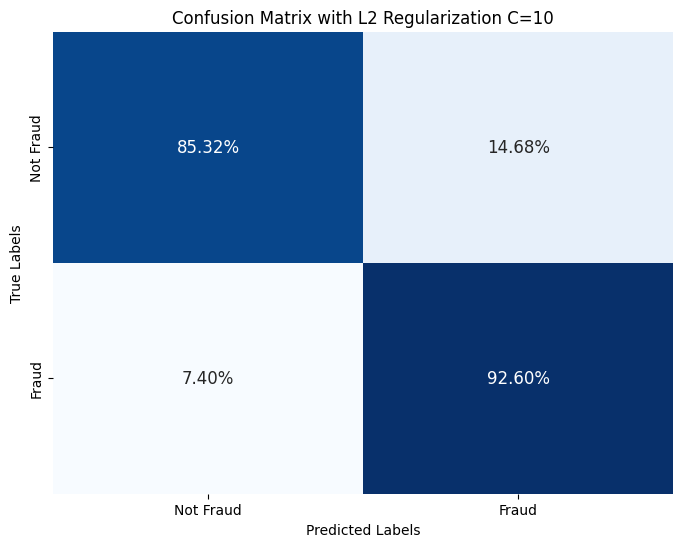

-----------------------------------------------------------------
                    Classification Report
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      3897
           1       0.48      0.93      0.64       581

    accuracy                           0.86      4478
   macro avg       0.74      0.89      0.78      4478
weighted avg       0.92      0.86      0.88      4478

age: 0.00712
amt: 0.00826
hour: 1.16757
category: 1.15514


In [28]:
#Create a model with C value of 10 for better generalization.
log_reg_l2 = LogisticRegression(max_iter=1000, random_state=rState, solver='liblinear', C=10, penalty='l2')

#Fit the model to the training data.
log_reg_l2.fit(X_train, y_train)

#Predict on the test set.
y_prob_second = log_reg_l2.predict_proba(X_test)[:, 1]
y_pred_second = (y_prob_second > prediction_threshold).astype(int) #Convert probabilities to binary predictions.

#Create a confusion matrix to show the performance of the model.
final_cm = confusion_matrix(y_test, y_pred_second, normalize="true")
plt.figure(figsize=(8, 6))
sns.heatmap(final_cm, annot=True, fmt='.2%', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels, annot_kws={"size": 12})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with L2 Regularization C=10')
plt.show()

#Print classification report for final model.
print("-" * 65)
print(' ' * 20 + "Classification Report")
print(classification_report(y_test, y_pred_second))

#Print feature weights.
coefs = log_reg_l2.coef_[0]  #2D array, so grab the first row for binary classification.

for feature_name, coef in zip(X_features, coefs):
    print(f"{feature_name}: {coef:.5f}")

# AUPRC with L2 Regularization

AUPRC: 0.8129


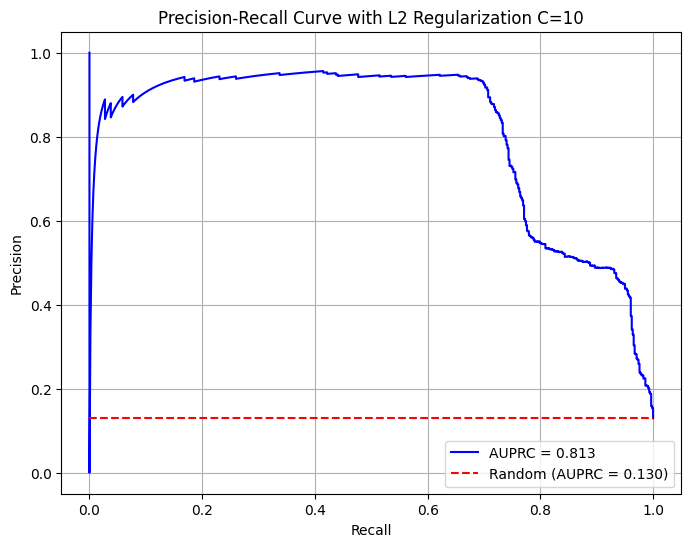

In [29]:
#Calculate precision-recall curve.
precision, recall, thresholds = precision_recall_curve(test_data['is_fraud'], y_prob_second)

#Calculate area under precision-recall curve.
auprc = average_precision_score(test_data['is_fraud'], y_prob_second)

#Print the AUPRC score.
print(f"AUPRC: {auprc:.4f}")

#Plot the precision-recall curve.
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label=f'AUPRC = {auprc:.3f}')

#Add a line for random performance (class imbalance ratio).
random = len(test_data[test_data['is_fraud'] == 1]) / len(test_data)
plt.plot([0, 1], [random, random], 'r--', label=f'Random (AUPRC = {random:.3f})')

#Add labels and title, then show the plot.
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with L2 Regularization C=10')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Hyperparameter Tuning with Stratified K-fold Cross-Validation

In [30]:
#Apply get_dummies to categorical columns before splitting to one-hot encode them.
df_copy = pd.get_dummies(df, columns=['hour', 'category'], drop_first=False)


#Select features to use for hyperparameter tuning after the L2 feature selection process.
include = ['hour_', 'category_', 'age', 'amt']
pattern = '^(' + '|'.join(include) + ')' #Create a pattern to match the features we want to include (this is for the hour and category columns, since they are one-hot encoded).

selected_features = df_copy.columns[df_copy.columns.str.match(pattern)]  #Select features based on the pattern.

test_sizes = [0.1, 0.2, 0.3, 0.31, .35, .4]  #Different test sizes to try.
thresholds = [0.1, 0.1275, .15, 0.2, 0.3, 0.5, 0.7]  #Different thresholds to try.

#Initialize StratifiedKFold for cross-validation. Better for imbalanced data.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rState) #5-fold cross-validation.

#List to store results for heatmap.
results = []

#For each test size and threshold combination, train and evaluate a model.
for test_size in test_sizes:
    for threshold in thresholds:
        
        #For each fold, split into training and testing sets.
        for train_idx, val_idx in cv.split(df_copy[selected_features], df_copy['is_fraud']):
            #Get the training and validation data.
            X_train, X_val = df_copy.iloc[train_idx][selected_features], df_copy.iloc[val_idx][selected_features]
            y_train, y_val = df_copy.iloc[train_idx]['is_fraud'], df_copy.iloc[val_idx]['is_fraud']
            
            #Further split the training set into a train and validation set.
            X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(X_train, y_train, test_size=test_size, stratify=y_train, random_state=rState)

            #Initialize the logistic regression model with L2 regularization. Same as previous models except very first non-L2 model.
            model = LogisticRegression(max_iter=1000, random_state=rState, solver='liblinear', C=10, penalty='l2', n_jobs=-1)

            #Fit the model to the training data.
            model.fit(X_train_part, y_train_part)

            #Get probabilities for the positive class.
            probs = model.predict_proba(X_val_part)[:, 1]

            #Apply threshold to get binary predictions.
            preds = (probs >= threshold).astype(int)

            #Calcualte recall, precision, and AUPRC for the validation set.
            recall_val = recall_score(y_val_part, preds)
            precision_val = precision_score(y_val_part, preds)
            auprc_val = average_precision_score(y_val_part, probs)

            #Store the results.
            results.append({
                "Test Size": test_size,
                "Threshold": threshold,
                "Recall": recall_val,
                "Precision": precision_val,
                "AUPRC": auprc_val
            })

#Convert results to a DataFrame.
results_df = pd.DataFrame(results)

#Print the results of each fold. Commented out to make pdf shorter.
# print(results_df)


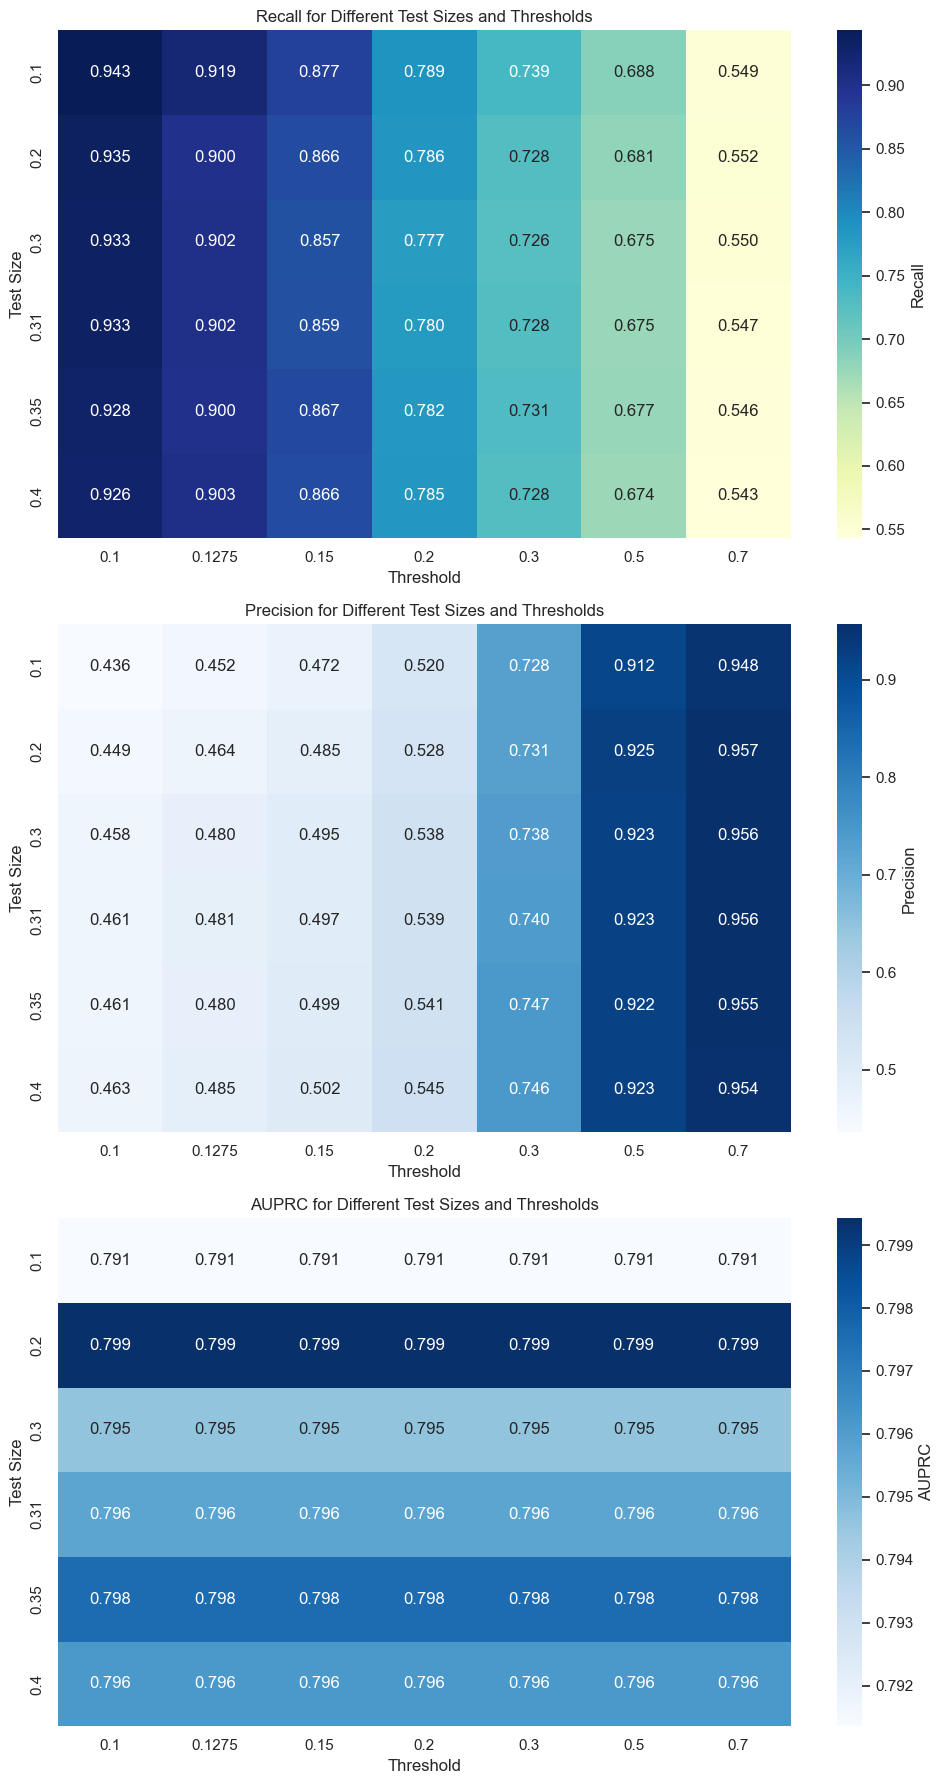

In [31]:
sns.set_theme(style="whitegrid")

#Got help from ChatGPT to create plot with multiple heatmap subplots. Mainly the color maps.
#Create a figure with 3 subplots.
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

#Pivot the results for each metric.
results_pivot_recall = results_df.pivot_table(index='Test Size', columns='Threshold', values='Recall')
results_pivot_precision = results_df.pivot_table(index='Test Size', columns='Threshold', values='Precision')
results_pivot_auprc = results_df.pivot_table(index='Test Size', columns='Threshold', values='AUPRC')

#Plot Recall.
sns.heatmap(results_pivot_recall, annot=True, cmap="YlGnBu", fmt=".3f", cbar_kws={'label': 'Recall'}, ax=axes[0])
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Test Size')
axes[0].set_title('Recall for Different Test Sizes and Thresholds')

#Plot Precision.
sns.heatmap(results_pivot_precision, annot=True, cmap="Blues", fmt=".3f", cbar_kws={'label': 'Precision'}, ax=axes[1])
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Test Size')
axes[1].set_title('Precision for Different Test Sizes and Thresholds')

#Plot AUPRC.
sns.heatmap(results_pivot_auprc, annot=True, cmap="Blues", fmt=".3f", cbar_kws={'label': 'AUPRC'}, ax=axes[2])
axes[2].set_xlabel('Threshold')
axes[2].set_ylabel('Test Size')
axes[2].set_title('AUPRC for Different Test Sizes and Thresholds')

plt.tight_layout()  #Adjust spacing between subplots to make it look better.
plt.show()